# Imports

In [3]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM,GRU,Dense,MaxPooling1D,Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import add,Conv1D
from tensorflow.keras.layers import Input,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping




from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

# Data Preprocessing

In [4]:
os.listdir('C:/Users/u144572/self_development/machine_learning_rr_detection/Respiratory_Sound_Database/')
df_no_diagnosis = pd.read_csv('C:/Users/u144572/self_development/machine_learning_rr_detection/Respiratory_Sound_Database/demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')

diagnosis = pd.read_csv('C:/Users/u144572/self_development/machine_learning_rr_detection/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [5]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

Diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

In [6]:
root = 'C:/Users/u144572/self_development/machine_learning_rr_detection/Respiratory_Sound_Database/audio_and_txt_files/'

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

## Read Respiratory Cycle Data

In [7]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [8]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

my_index = pd.Series(list(rec_annotations_dict.keys()))

## Get Respiratory Cycle length and Diagnosis

In [9]:
res_rate_list = []
for i in range (920):
    cycle_df = pd.DataFrame( list(rec_annotations_dict.values())[i],columns=['Start', 'End' ,'cycle length'])
    cycle_df['cycle length'] = cycle_df['End']-cycle_df['Start']
    average = cycle_df[["Start","End","cycle length"]].mean(axis=0)
    df = pd.DataFrame(average).T
    res_rate_list.append(df)

In [10]:
res_rate_df = pd.concat(res_rate_list,ignore_index =True)
res_rate_df['filename']= my_index.values
res_rate_df['filename']= res_rate_df['filename'].str[:3]
res_rate_df.sort_values(by=['filename'])

,Start,End,cycle length,filename
0,8.639333,10.300000,1.660667,101
1,9.365636,11.174727,1.809091,101
2,9.807231,11.322615,1.515385,102
3,8.778667,12.047833,3.269167,103
4,5.434450,8.077117,2.642667,104
...,...,...,...,...
915,9.980571,12.831571,2.851000,224
916,9.587714,11.012214,1.424500,225
918,8.942800,10.927100,1.984300,226
917,8.444400,10.438600,1.994200,226


In [55]:
# Respiratory cycle = Cycle length // 60 seconds 
avg = res_rate_df.groupby('filename').mean()
avg['respiratory rate'] = 60 // avg['cycle length'] 

# Normal Respiratory Rate (12-25) cycle/min
avg['diagnosis'] = 'out of range'
step = 1
start = 10
stop = 50

categories = []
# avg['diagnosis'][(avg['respiratory rate'] > 25 )] = "High" 
for x in range(start, stop, step):
    category = str(x)
    avg['diagnosis'][((avg['respiratory rate'] >= x) & (avg['respiratory rate'] < x + step))] = category
    categories.append(category)
categories.append('out of range')
avg.diagnosis

C:\Users\u144572\AppData\Local\Temp\ipykernel_24844\3640920184.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg['diagnosis'][((avg['respiratory rate'] >= x) & (avg['respiratory rate'] < x + step))] = category
C:\Users\u144572\AppData\Local\Temp\ipykernel_24844\3640920184.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg['diagnosis'][((avg['respiratory rate'] >= x) & (avg['respiratory rate'] < x + step))] = category
C:\Users\u144572\AppData\Local\Temp\ipykernel_24844\3640920184.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

filename
101    34
102    39
103    18
104    26
105    24
       ..
222    12
223    19
224    21
225    42
226    31
Name: diagnosis, Length: 126, dtype: object

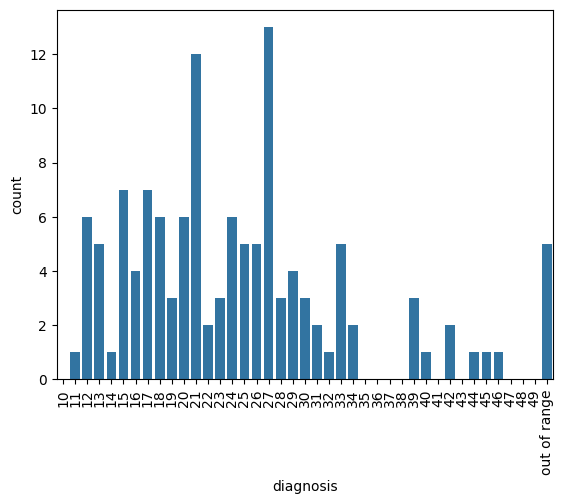

In [20]:
sns.countplot(x=avg.diagnosis, order=categories)
my_plt = plt.xticks(rotation=90)

## Save Diagnosis Data

In [22]:
avg.diagnosis.to_csv('respiratory_rate_step_1.csv')

## Data Augmentation

In [23]:
audio_data = 'C:/Users/u144572/self_development/machine_learning_rr_detection/Respiratory_Sound_Database/audio_and_txt_files/'

In [24]:
rr_diagnosis_df = pd.read_csv('respiratory_rate_step_1.csv', names=['patient_id', 'disease'],header=0)
rr_diagnosis_df.head(4)

,patient_id,disease
0,101,34
1,102,39
2,103,18
3,104,26


In [25]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [26]:
def mfcc_feature_exteraction_rr(dir_):
    X_=[]
    y_=[]
    COPD=[]
    copd_count=0
    data = rr_diagnosis_df
    features = 50
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav':

            label = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]
            
            if (label == 'Normal'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
                
            if (label != 'Normal'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
                
                data_shift = shift(data_x,1600)
                mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_shift)
                y_.append(label)
                
                data_noise = add_noise(data_x,0.005)
                mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_noise)
                y_.append(label)
           
                
    X_data = np.array(X_)
    y_data = np.array(y_)
    
    
    
    return X_data ,y_data

In [27]:
res_data, res_y = mfcc_feature_exteraction_rr(audio_data)

In [30]:
unique, counts = np.unique(res_y, return_counts=True)
data_count = dict(zip(unique, counts))

data = data_count

courses = list(data.keys())
values = list(data.values())

In [56]:
res_y_data_encode = res_y.reshape(2760,1)
cat_num = len(categories)
for index, category in enumerate(categories):
    lable = []
    for x in range(len(categories)):
        if x == index:
            lable.append(1)
        else:
            lable.append(0)
    res_y_data_encode = np.where(res_y_data_encode == category, np.array(lable).reshape(1, cat_num), res_y_data_encode)

res_lables = res_y_data_encode.astype('float64')

In [57]:
res_features = np.array(res_data)
res_lables = np.array(res_lables)

res_features.shape , res_lables.shape

((2760, 50), (2760, 41))

## Data Split

In [58]:
x_train, x_val, y_train, y_val  = train_test_split(res_features, res_lables, test_size=0.175, random_state=10)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.075, random_state=10)


print (x_train.shape, x_val.shape, x_test.shape)
print (y_train.shape, y_val.shape, y_test.shape)

(2106, 50) (483, 50) (171, 50)
(2106, 41) (483, 41) (171, 41)


# LSTM Model

In [59]:
x_train_lstm = np.expand_dims(x_train,axis=2)
x_val_lstm = np.expand_dims(x_val,axis=2)
x_test_lstm = np.expand_dims(x_test,axis=2)

## Build Model

In [60]:
model = Sequential()

model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())


model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(len(categories), activation='softmax'))


model.summary()

C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 52, 2048)       │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 26, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 2048)       │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 1024)       │    10,486,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 13, 512)        │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 7, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 41)             │         1,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,131,625 (53.91 MB)

 Trainable params: 14,124,457 (53.88 MB)

 Non-trainable params: 7,168 (28.00 KB)

In [61]:
tf.keras.utils.plot_model(model, "net.png", show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [62]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [63]:
cb = [EarlyStopping(patience=20,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("/kaggle/working/rr_LSTM_CNN_1.keras",save_best_only=True)]

## Train Model

In [64]:
history = model.fit(x_train_lstm, y_train, batch_size=16, epochs=10, validation_data=(x_val_lstm, y_val),callbacks = cb)

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 37s 257ms/step - accuracy: 0.0511 - loss: 3.6425 - val_accuracy: 0.1097 - val_loss: 3.5618
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - accuracy: 0.0745 - loss: 3.5386 - val_accuracy: 0.0704 - val_loss: 3.4791
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 256ms/step - accuracy: 0.0750 - loss: 3.4942 - val_accuracy: 0.0932 - val_loss: 3.3975
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.0759 - loss: 3.4445 - val_accuracy: 0.0642 - val_loss: 3.2472
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 33s 253ms/step - accuracy: 0.0695 - loss: 3.3942 - val_accuracy: 0.0973 - val_loss: 3.2949
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 255ms/step - accuracy: 0.0935 - loss: 3.3511 - val_accuracy: 0.1077 - val_loss: 3.2555
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step - accuracy: 0.0791 - loss: 3.2960 - val_accuracy: 0.1139 - val_loss: 3.1240
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 36s 271ms/step - accuracy: 0.0880 - loss: 3

## Evaluate Model

In [65]:
model.evaluate(x_val_lstm, y_val)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.1271 - loss: 3.0518


[3.036027669906616, 0.11801242083311081]

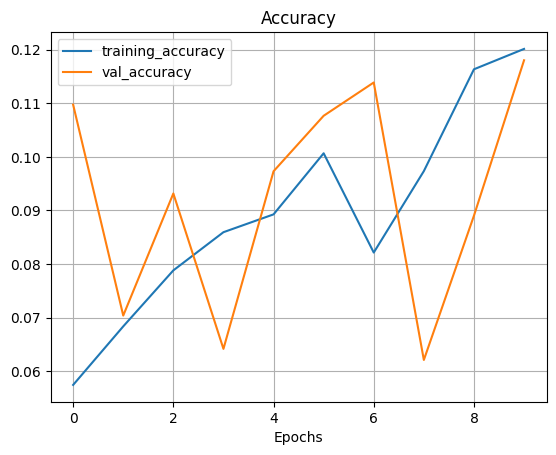

In [66]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
#   plt.plot(epochs, loss, label='training_loss')
#   plt.plot(epochs, val_loss, label='val_loss')
#   plt.title('Loss')
#   plt.xlabel('Epochs')
#   plt.legend()
#   plt.grid()


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history)

## Results

In [68]:
preds

array([[0.00861357, 0.01946081, 0.03027773, ..., 0.00594295, 0.00531412,
        0.02222221],
       [0.00941862, 0.01627316, 0.02732269, ..., 0.00738478, 0.00752792,
        0.01529624],
       [0.00549591, 0.01541378, 0.02252702, ..., 0.0030836 , 0.00468821,
        0.02086916],
       ...,
       [0.00869018, 0.01589501, 0.02695793, ..., 0.00659619, 0.00725549,
        0.01492921],
       [0.00824698, 0.01882898, 0.03177451, ..., 0.005539  , 0.00447777,
        0.0235562 ],
       [0.00698133, 0.01735797, 0.02655309, ..., 0.00474598, 0.0059797 ,
        0.01848057]], dtype=float32)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


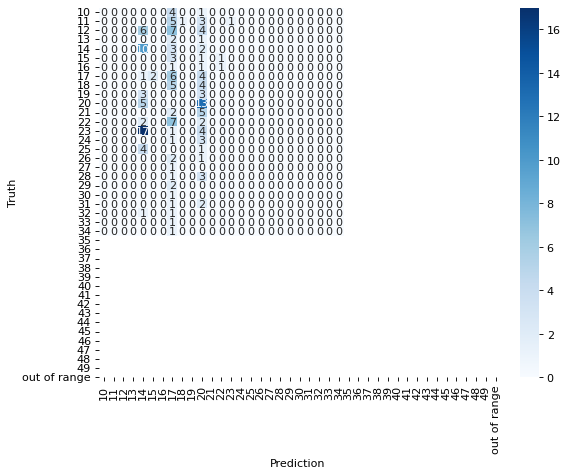

In [67]:
classes = categories

preds = model.predict(x_test_lstm)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [102]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

     10 - 15       0.75      0.80      0.77        15
     15 - 20       0.95      0.84      0.89        43
     20 - 25       0.88      0.83      0.85        53
     25 - 30       0.75      0.98      0.85        45
     30 - 35       0.71      0.62      0.67         8
     35 - 40       0.00      0.00      0.00         3
out of range       1.00      0.25      0.40         4

    accuracy                           0.83       171
   macro avg       0.72      0.62      0.63       171
weighted avg       0.83      0.83      0.82       171



C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

## Prediction

In [31]:
def respiratory_rate_prediction(audio_path):
    
    classes = ["Normal", "High"]
    
    #load aduio with 22050 Hz sampling rate
    data_x, sampling_rate = librosa.load(audio_path)
    
    #extract feature using mfcc (50 features)
    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=50).T,axis = 0)

    features = features.reshape(1,50)
    
    #get the prediction and the confidence 
    test_pred = model.predict(np.expand_dims(features, axis = 2))
    classpreds = classes[np.argmax(test_pred, axis=1)[0]]
    confidence = test_pred.T[test_pred.mean(axis=0).argmax()].mean()

    print (classpreds, confidence)

In [32]:
respiratory_rate_prediction('/kaggle/input/audio-test/74.wav')

High 0.99999475


# GRU Model

In [33]:
x_train_gru = np.expand_dims(x_train,axis=1)
x_val_gru = np.expand_dims(x_val,axis=1)
x_test_gru = np.expand_dims(x_test,axis=1)

y_train_gru = np.expand_dims(y_train,axis=1)
y_val_gru = np.expand_dims(y_val,axis=1)
y_test_gru = np.expand_dims(y_test,axis=1)

## Build Model

In [34]:
Input_Sample = Input(shape=(1,50))

model_conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(Input_Sample)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_conv = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(model_conv)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_2_1 = GRU(32,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_2 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_2_1)

model_3 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_3 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_3)

model_add_1 = add([model_3,model_2])

model_5 = GRU(128,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_5 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_5)

model_6 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_6 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_6)

model_add_2 = add([model_5,model_6,model_2_1])


model_7 = Dense(32, activation=None)(model_add_2)
model_7 = LeakyReLU()(model_7)
model_7 = Dropout(0.2)(model_7)
model_7 = Dense(128, activation=None)(model_7)
model_7 = LeakyReLU()(model_7)

model_9 = Dense(64, activation=None)(model_add_2)
model_9 = LeakyReLU()(model_9)
model_9 = Dropout(0.2)(model_9)
model_9 = Dense(128, activation=None)(model_9)
model_9 = LeakyReLU()(model_9)

model_add_3 = add([model_7,model_9])

model_10 = Dense(64, activation=None)(model_add_3)
model_10 = LeakyReLU()(model_10)
model_10 = Dropout(0.5)(model_10)

model_10 = Dense(32, activation=None)(model_10)
model_10 = LeakyReLU()(model_10)
model_10 = Dropout(0.3)(model_10)

model_10 = Dense(2, activation="softmax")(model_10)

GRU_model = Model(inputs=Input_Sample, outputs = model_10)

GRU_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 50)]      0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 1, 256)       64256       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 1, 256)       0           conv1d_3[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 1, 256)       1024        max_pooling1d_3[0][0]            
______________________________________________________________________________________________

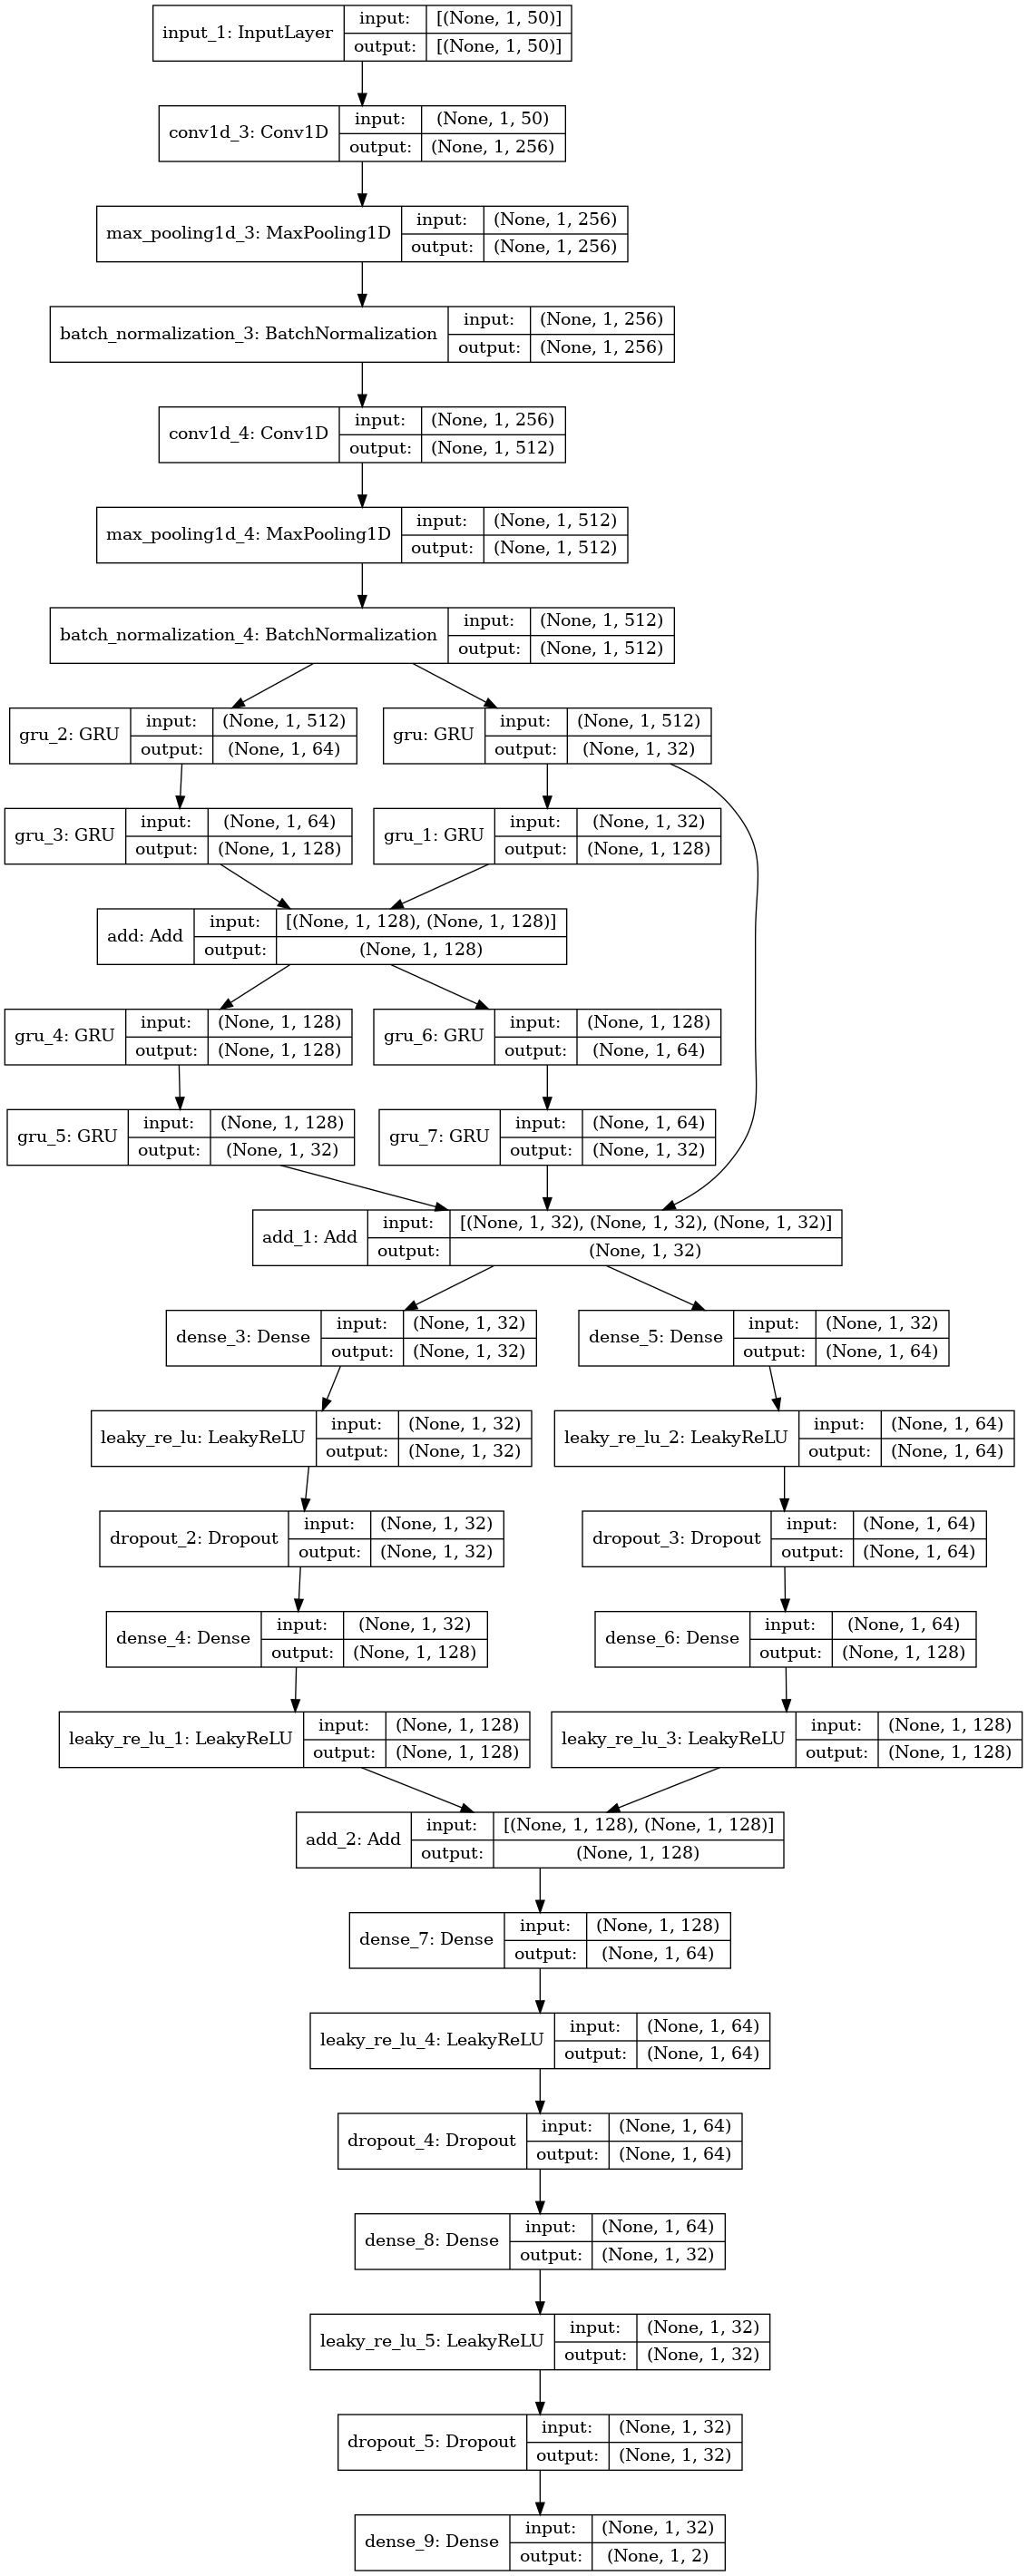

In [35]:
tf.keras.utils.plot_model(GRU_model, "GRU.png", show_shapes=True)

In [36]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
GRU_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [37]:
cb = [EarlyStopping(patience=20,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("/kaggle/working/rr_GRU_CNN_1.h5",save_best_only=True)]

## Train Model

In [38]:
history = GRU_model.fit(x_train_gru, y_train_gru, batch_size=16, epochs=250, validation_data=(x_val_gru, y_val_gru),callbacks = cb )

Epoch 1/250
66/66 [==============================] - 13s 48ms/step - loss: 0.6515 - accuracy: 0.5741 - val_loss: 0.6889 - val_accuracy: 0.5496
Epoch 2/250
 5/66 [=>............................] - ETA: 0s - loss: 0.6278 - accuracy: 0.6250

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


66/66 [==============================] - 1s 16ms/step - loss: 0.5699 - accuracy: 0.6863 - val_loss: 0.6409 - val_accuracy: 0.7190
Epoch 3/250
66/66 [==============================] - 1s 17ms/step - loss: 0.5235 - accuracy: 0.7405 - val_loss: 0.5498 - val_accuracy: 0.7851
Epoch 4/250
66/66 [==============================] - 1s 17ms/step - loss: 0.5063 - accuracy: 0.7471 - val_loss: 0.4702 - val_accuracy: 0.8636
Epoch 5/250
66/66 [==============================] - 1s 18ms/step - loss: 0.4824 - accuracy: 0.7576 - val_loss: 0.4320 - val_accuracy: 0.8388
Epoch 6/250
66/66 [==============================] - 1s 16ms/step - loss: 0.4592 - accuracy: 0.7842 - val_loss: 0.4012 - val_accuracy: 0.8636
Epoch 7/250
66/66 [==============================] - 1s 20ms/step - loss: 0.4464 - accuracy: 0.8118 - val_loss: 0.4417 - val_accuracy: 0.8140
Epoch 8/250
66/66 [==============================] - 2s 23ms/step - loss: 0.4209 - accuracy: 0.8222 - val_loss: 0.3767 - val_accuracy: 0.8388
Epoch 9/250
66/66 

## Evaluate Model

8/8 [==============================] - 0s 9ms/step - loss: 0.1553 - accuracy: 0.9421


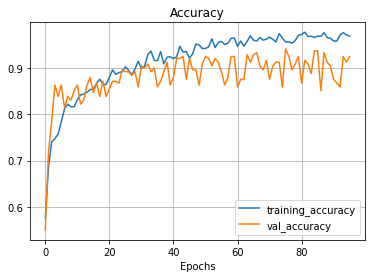

In [39]:
GRU_model.evaluate(x_val_gru, y_val_gru)
plot_loss_curves(history)

## Results

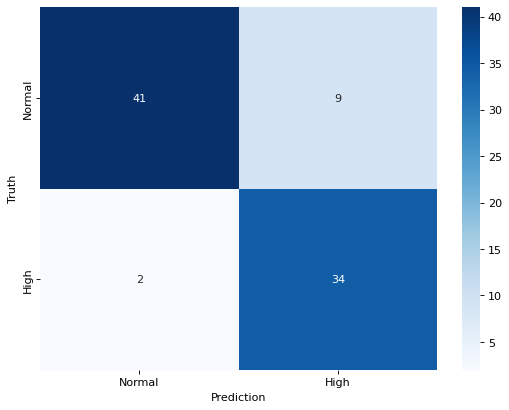

In [40]:
classes = ["Normal", "High"]

preds = GRU_model.predict(x_test_gru)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_gru]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [41]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

      Normal       0.95      0.82      0.88        50
        High       0.79      0.94      0.86        36

    accuracy                           0.87        86
   macro avg       0.87      0.88      0.87        86
weighted avg       0.89      0.87      0.87        86



## Prediction

In [42]:
def respiratory_rate_prediction_gru(audio_path):
    
    classes = ["Normal", "High"]
    
    #load aduio with 22050 Hz sampling rate
    data_x, sampling_rate = librosa.load(audio_path)
    
    #extract feature using mfcc (50 features)
    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=50).T,axis = 0)

    features = features.reshape(1,50)
    
    #get the prediction and the confidence 
    test_pred = GRU_model.predict(np.expand_dims(features, axis = 1))
    classpreds = classes[np.argmax(test_pred[0], axis=1)[0]]
    confidence = test_pred.T[test_pred[0].mean(axis=0).argmax()].mean()

    print (classpreds, confidence)

In [43]:
respiratory_rate_prediction_gru('/kaggle/input/audio-test/74.wav')

High 0.99998343
